In [2]:
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [5]:
from os.path import join

import pymc3 as pm
import theano.tensor as tt
import theano

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Warm-up: softmax in theano

In [104]:
# declare variables and softmax
v = tt.vector('v', dtype=np.float32)
tau = tt.scalar('tau')
softmax = 1 / (1 + tt.exp(tau * (v[1] - v[0])))

func = theano.function([tau, v], [softmax])

TypeError: Unsupported dtype for TensorType: <class 'numpy.float32'>

In [105]:
# run softmax for a couple of dummy 
res = []
va = 1.0
vb_values = np.linspace(-5, 5)
tau = 3

for v_ in [(va, x) for x in vb_values]:
    v = np.asarray(v_, dtype=np.float32)
    out = func(tau, v)
    print(f'In: {v}, out: {out[0]}')
    res.append(out[0])
plt.plot(vb_values, res)

TypeError: Bad input argument to theano function with name "<ipython-input-102-fef7464360ae>:6" at index 1 (0-based).  
Backtrace when that variable is created:

  File "D:\py-related\anaconda\envs\mypm3env\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\py-related\anaconda\envs\mypm3env\lib\site-packages\IPython\core\interactiveshell.py", line 2876, in run_cell
    result = self._run_cell(
  File "D:\py-related\anaconda\envs\mypm3env\lib\site-packages\IPython\core\interactiveshell.py", line 2922, in _run_cell
    return runner(coro)
  File "D:\py-related\anaconda\envs\mypm3env\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "D:\py-related\anaconda\envs\mypm3env\lib\site-packages\IPython\core\interactiveshell.py", line 3145, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "D:\py-related\anaconda\envs\mypm3env\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "D:\py-related\anaconda\envs\mypm3env\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-102-fef7464360ae>", line 2, in <module>
    v = tt.ivector('v')
TensorType(int32, vector) cannot store a value of dtype float32 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to int32, or 2) set "allow_input_downcast=True" when calling "function". Value: "array([ 1., -5.], dtype=float32)"

In [38]:
rl_mp = {}
df = pd.read_csv(join('_data', 'rl_mp.csv'))
rl_mp['choice'] = df.iloc[:, :100] - 1
rl_mp['reward'] = df.iloc[:, 100:]

nSubjects, nTrials = rl_mp['choice'].shape

In [40]:
nIter = 1000
nChains = 4
nWarmup = 1000

In: [ 1 -4], out: [array(0.5)]
In: [ 1 -3], out: [array(0.5)]
In: [ 1 -2], out: [array(0.5)]
In: [ 1 -1], out: [array(0.5)]
In: [1 0], out: [array(0.5)]
In: [1 1], out: [array(0.5)]
In: [1 2], out: [array(0.5)]
In: [1 3], out: [array(0.5)]
In: [1 4], out: [array(0.5)]


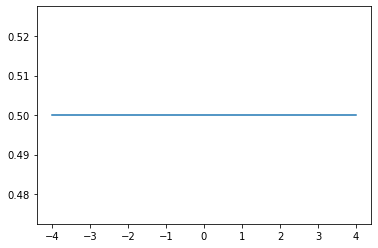

In [55]:
def softmax(tau, v):
    return 1 / (1 + tt.exp(v[1] - v[0]))

In [ ]:
with pm.Model() as pm:
    alpha = pm.Uniform('alpha', 0, 1)   
    tau = pm.Uniform('tau', 0, 3)
    
    v = tt.ivector('v')
    
    
    
    pm